In [79]:
from openai_api import client

from crawler import crawl, TextToCSVClass, get_shortened
import pandas as pd
import tiktoken

In [80]:
domain = "pdza.org"  # <- put your domain to be crawled
full_url = "https://pdza.org/sea-turtle-check-up/"  # <- put your domain to be crawled with https or http

In [81]:
crawl(full_url)
TextToCSVClass(domain).to_csv()

https://pdza.org/sea-turtle-check-up/


<Axes: >

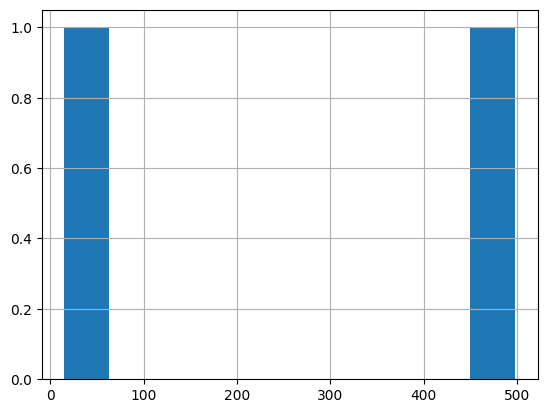

In [82]:
tokenizer = tiktoken.get_encoding("cl100k_base")
shortened = get_shortened()
df = pd.DataFrame(shortened, columns=['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [83]:
df['embeddings'] = df.text.apply(
    lambda x: client.embeddings.create(input=x, model='text-embedding-ada-002').data[0].embedding)

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,rg sea turtle check up . display;width;text-al...,15,"[-0.005271165166050196, 0.007509703282266855, ..."
1,a turtle check up . Sea Turtle Check-Up - ...,498,"[0.025263050571084023, -0.001983973430469632, ..."


In [84]:
import numpy as np
from scipy import spatial

df = pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,rg sea turtle check up . display;width;text-al...,15,"[-0.005271165166050196, 0.007509703282266855, ..."
1,a turtle check up . Sea Turtle Check-Up - ...,498,"[0.025263050571084023, -0.001983973430469632, ..."


In [109]:
def create_context(
    question, dataframe, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding
    
    df['distances'] = [[] for _ in range(len(df))]
    # Get the distances from the embeddings
    for i in range(0,len(dataframe['embeddings'])):
        dataframe['distances', i] = 1 - spatial.distance.cosine(q_embeddings, dataframe['embeddings'][i])


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in dataframe.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [115]:
def answer_question(
        dataframe,
        model="gpt-3.5-turbo",
        question="Am I allowed to publish model outputs to Twitter, without a human review?",
        max_len=1800,
        size="ada",
        max_tokens=150,
        stop_sequence=None
):
    context = create_context(
        question,
        dataframe,
        max_len=max_len,
        size=size,
    )
    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system",
                 "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\n"},
                {"role": "user", "content": f"Context: {context}\n\n---\n\nQuestion: {question}\nAnswer:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

In [116]:
answer_question(df, question="Is this page about ponies?")

'No, this page is not about ponies.'